In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import vigra
from vigra import graphs
import copy
import os
import pylab
import time
from scipy.io import loadmat
import sys

import inferno
import multicutAuxFunctions as maf

# Training

In [2]:
trainSetPath = 'trainingSet/'
#trainSetPath = 'oneImage/'


path = os.walk(trainSetPath)

trainingIds = []
trainingImgs = []

gtLabels = []
gtSols = []

trainingRags = []

superpixelDiameter = 20      # super-pixel size
slicWeight         = 25.0    # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50      # desired num. nodes in result
minSize            = 15

############# load images and convert to LAB #############
for root, dirs, files in path:
    jpgFiles = [filename for filename in files if filename.endswith('.jpg')]
    T = len(jpgFiles)
    for i, filename in enumerate(jpgFiles):
        
        sys.stdout.write('\r')
        sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
        sys.stdout.flush()

        fileId = filename[:-4]
        trainingIds.append(fileId)
        
        img = vigra.impex.readImage(root + '/' + filename)
        trainingImgs.append(img)
        imgLab = vigra.colors.transform_RGB2Lab(img)
            
        gridGraph = graphs.gridGraph(img.shape[0:2])

        slicLabels = vigra.analysis.labelImage(vigra.analysis.slicSuperpixels(imgLab, slicWeight, superpixelDiameter, minSize=minSize)[0])
        rag = graphs.regionAdjacencyGraph(gridGraph, slicLabels)
        trainingRags.append(rag)
        
        gtWatershed = loadmat('trainingSet/groundTruth/' + fileId + '.mat')['groundTruth'][0,0][0][0][0]
        gtLabel = maf.getSuperpixelLabelList(rag, gtWatershed)
        gtLabels.append(gtLabel)
                
        gtSols.append(maf.getGroundTruthSol(rag, gtLabel))

        

[==================================================] 100%

Maximum Number of Edges in an image: 1734
Minimum Number of Edges in an image: 1043
Mean Number of Edges in an image: 1197.86


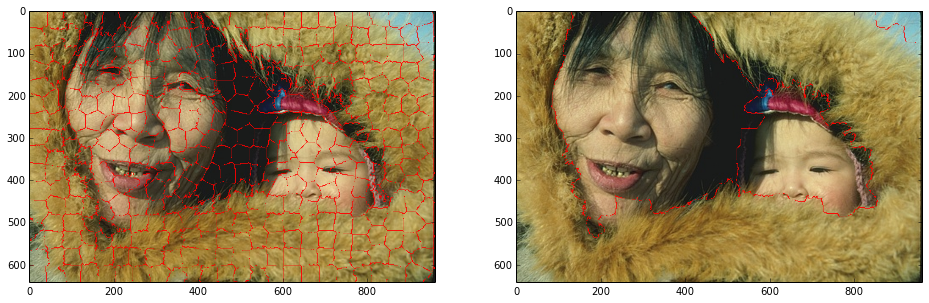

In [3]:
i = 0

print 'Maximum Number of Edges in an image:', max([e.edgeNum for e in trainingRags])
print 'Minimum Number of Edges in an image:', min([e.edgeNum for e in trainingRags])
print 'Mean Number of Edges in an image:', np.mean([e.edgeNum for e in trainingRags])


f = pylab.figure(figsize=(16,16))
ax0 = f.add_subplot(121)
trainingRags[i].show(trainingImgs[i], edgeColor=(1,0,0), alpha=0.)

ax1 = f.add_subplot(122)
trainingRags[i].show(trainingImgs[i], edgeColor=(1,0,0), alpha=0., labels=gtLabels[i])

vigra.show()

In [4]:
trainingFeatureSpaces = []
trainingEdges = []
t1 = time.time()
T = len(trainingImgs)
for i, (rag, img, trainId) in enumerate(zip(trainingRags, trainingImgs, trainingIds)):
    trainingEdges.append(rag.uvIds().astype('uint64'))

    features, trainingFeatureNames = maf.getFeatures(rag, img, trainId)
    
    sys.stdout.write('\r')
    sys.stdout.write("[%-50s] %d%%" % ('='*int(float(i+1)/T*50), int(float(i+1)/T*100)))
    sys.stdout.flush()
    
    trainingFeatureSpaces.append(features)
t2 = time.time()

print "\nTime to built up Feature Space:", t2-t1, "sec"


[==================================================] 100%
Time to built up Feature Space: 265.550325871 sec


In [5]:
# Null Feature Vector für VOI ohne RF
#trainingFeatureSpaces[:] = [np.concatenate((featureSpace, np.zeros((featureSpace.shape[0], 1))), axis=1) for featureSpace in trainingFeatureSpaces]

In [6]:
RF = maf.buildRandomForest(trainingFeatureSpaces, gtSols)

In [7]:
trainingRfProbs = maf.getProbsFromRF(trainingFeatureSpaces, RF)

trainingFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(trainingFeatureSpaces, trainingRfProbs)]
trainingFeatureNames.extend(('RF_Prob1', 'RF_Prob2'))

In [5]:


weightVector = maf.performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels, loss='partitionHamming')
#weightVector = maf.performLearning(trainingFeatureSpaces, trainingRags, trainingEdges, gtLabels, loss='variationOfInformation')

Begin weight learning...
Learning Duration:  155.76760602 sec


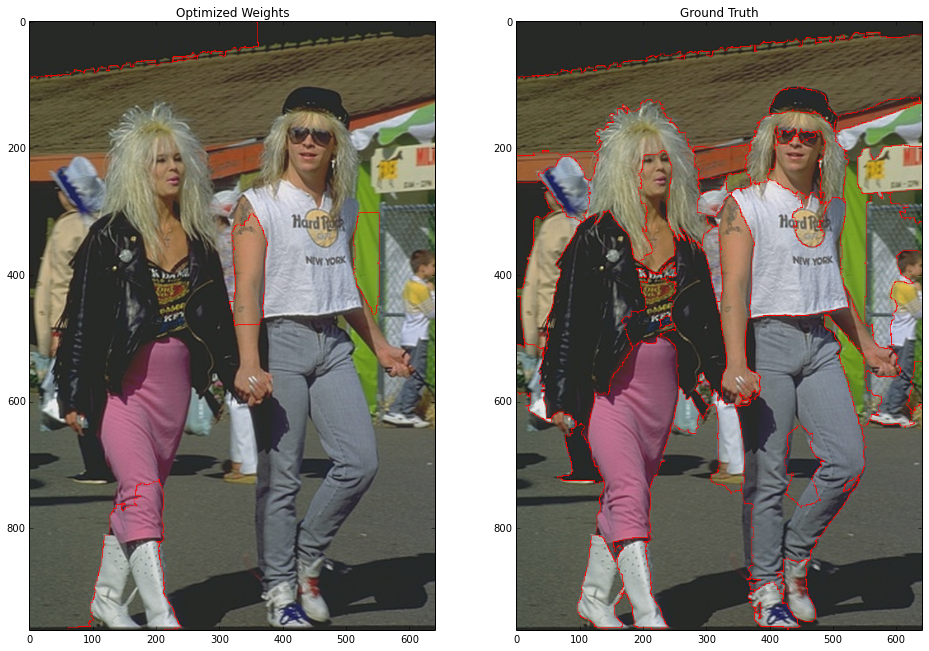

In [6]:
ParaMcModel = inferno.models.ParametrizedMulticutModel

nTrainSamples = len(trainingImgs)

modelVec = ParaMcModel.modelVector(nTrainSamples)

for n in range(nTrainSamples):

    nVar = trainingRags[n].nodeNum
    modelVec[n]._assign(nVar, trainingEdges[n]-1, trainingFeatureSpaces[n], weightVector) # -1 at edges so that nodes start at 0


############ Use Multicut on training image with given weightVector ###############
i = 10

if (i >= nTrainSamples or i < 0):
    print "i invalid! i was set to 0 for now!"
    i = 0

solver = inferno.inference.multicut(modelVec[i])

visitor = inferno.inference.verboseVisitor(modelVec[i])
solver.infer(visitor.visitor())

conf = solver.conf()

arg = conf.view().astype('uint32')
arg = np.array([0] + list(arg), dtype=np.uint32) + 1

f = pylab.figure(figsize=(16,16))
ax0 = f.add_subplot(1,2,1)
trainingRags[i].show(trainingImgs[i], labels=arg, edgeColor=(1,0,0), alpha=0.)
ax0.set_title('Optimized Weights')

ax1 = f.add_subplot(1,2,2)
trainingRags[i].show(trainingImgs[i], labels=gtLabels[i], edgeColor=(1,0,0), alpha=0.)
ax1.set_title('Ground Truth')


pylab.show()

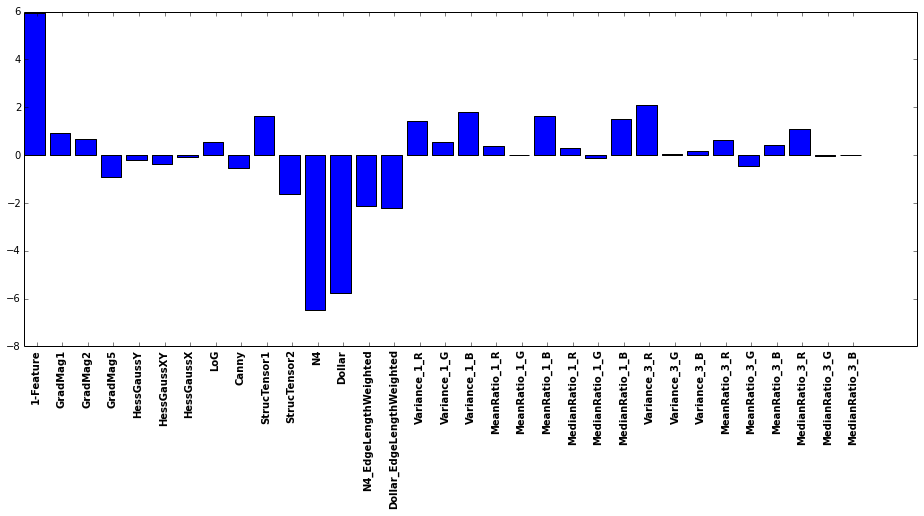

array([  5.92228576e+00,   9.08082774e-01,   6.66782440e-01,
        -9.03242557e-01,  -2.16451552e-01,  -3.66079380e-01,
        -9.72621810e-02,   5.29957615e-01,  -5.54944112e-01,
         1.63193402e+00,  -1.64616310e+00,  -6.46407849e+00,
        -5.74574403e+00,  -2.14516227e+00,  -2.23170838e+00,
         1.42169499e+00,   5.59330558e-01,   1.78481658e+00,
         3.90610803e-01,   1.13773159e-02,   1.63220550e+00,
         2.92826978e-01,  -1.09300410e-01,   1.50511281e+00,
         2.08226134e+00,   2.78814813e-02,   1.68413319e-01,
         6.40783614e-01,  -4.53874005e-01,   4.26709774e-01,
         1.08769357e+00,  -4.10953627e-02,   3.47276491e-03])

In [7]:
auxWeightVec = np.zeros(len(weightVector))
for w in range(len(weightVector)):
    auxWeightVec[w] = weightVector[w]

f = plt.figure(figsize=(16,6))
ax = f.add_subplot(111)

ax.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax.set_xticks(np.linspace(0.5, len(trainingFeatureNames)-0.5, len(trainingFeatureNames)))
ax.set_xticklabels(trainingFeatureNames, rotation=90, weight=550)
plt.show()

auxWeightVec

# Testing

In [12]:
########### Use previous calculated weights ########################################

'''### partition Hamming without edgeLengthWeighted N4/Dollar
weights = np.array([  7.22419899,   0.40247906,  -0.32125476,  -2.90153402,
    -0.51362044,   0.10224229,   0.2178948 ,   0.50556576,
    -2.55662064,   1.4081388 ,  -1.8826377 , -12.43351795,
    -10.56668765,  -0.11710111,  -0.29926287,  -1.29157775,
    0.71614733,   0.61672725,  -0.77740122,  -0.77069566,
     0.75244262,  -0.23765505,   1.63286551,   2.07582006,
    0.572415  ,  -0.04897844,  -0.07422355,  -1.07454004,
    -0.38744577,  -0.37478441,  -0.75440215])




weightVector = inferno.learning.WeightVector(weights.shape[0], 0.0)

for i in range(len(weightVector)):
    weightVector[i] = weights[i]
'''

-1

In [55]:
########### Work with learned Random Forest and weights on Test Set #################

testSetPath = 'testSet/'

path = os.walk(testSetPath)

testImgs = []
testIds = []

testRags = []


superpixelDiameter = 20       # super-pixel size
slicWeight         = 25.0     # SLIC color - spatial weight
beta               = 0.5     # node vs edge weight
nodeNumStop        = 50         # desired num. nodes in result
minSize            = 15


############# load images and convert to LAB #############
for root, dirs, files in path:
    for filename in files:
        if (filename.endswith('.jpg')):
            fileId = filename[:-4]
            testIds.append(fileId)
            img = vigra.impex.readImage(root + filename)
            imgLab = vigra.colors.transform_RGB2Lab(img)
            testImgs.append(img)

            gridGraph = graphs.gridGraph(img.shape[0:2])

            slicLabels = vigra.analysis.labelImage(vigra.analysis.slicSuperpixels(imgLab, slicWeight, superpixelDiameter, minSize=minSize)[0])
            rag = graphs.regionAdjacencyGraph(gridGraph, slicLabels)
            testRags.append(rag)


In [56]:
testFeatureSpaces = []
testEdges = []
for rag, img, trainId in zip(testRags, testImgs, testIds):
    testEdges.append(rag.uvIds().astype('uint64'))

    features = maf.getFeatures(rag, img, trainId)[0]
    print "Feature Vector built!"
    sys.stdout.flush()

    testFeatureSpaces.append(features)

Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!
Feature Vector built!


In [57]:
probs = maf.getProbsFromRF(testFeatureSpaces, RF)

testFeatureSpaces[:] = [np.concatenate((featureSpace, prob), axis=1) for featureSpace, prob in zip(testFeatureSpaces, probs)]

In [61]:
### build model

ParaMcModel = inferno.models.ParametrizedMulticutModel

nTestSamples = len(testImgs)
nFeatures = testFeatureSpaces[0].shape[1]

modelVec = ParaMcModel.modelVector(nTestSamples)

for n in range(nTestSamples):
    nVar = testRags[n].nodeNum
    modelVec[n]._assign(nVar, testEdges[n]-1, testFeatureSpaces[n], weightVector)


In [12]:
### solve
i = 0
if (i >= nTestSamples):
    print " i ungueltig!!!"
    sys.stdout.flush()
    i = 0

solver = inferno.inference.multicut(modelVec[i])

visitor = inferno.inference.verboseVisitor(modelVec[i])
solver.infer(visitor.visitor())

conf = solver.conf()

arg = conf.view().astype('uint32')
arg = np.array([0] + list(arg), dtype=np.uint32) + 1

f = pylab.figure(figsize=(12,12))
ax0 = f.add_subplot(111)
testRags[i].show(testImgs[i], labels=arg, edgeColor=(1,0,0), alpha=0.)
ax0.set_title('Optimized Weights Test Image')


#f.savefig('results/partitionHamming/withRandomForest/' + str(testIds[i]) + '.png')
#f.savefig('results/partitionHamming/' + str(testIds[i]) + '.png')
#f.savefig('results/variationOfInformation/edgeLengthWeighted_N4_Dollar/' + str(testIds[i]) + '.png')

NameError: name 'nTestSamples' is not defined

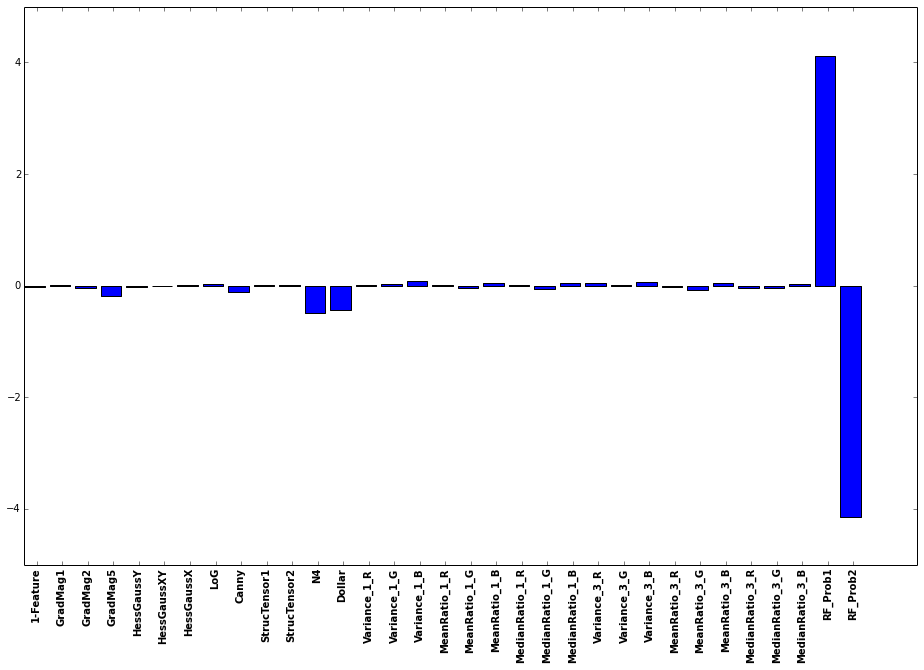

In [54]:
f = pylab.figure(figsize=(16,10))
ax1 = f.add_subplot(111)
ax1.bar(range(auxWeightVec.shape[0]), auxWeightVec)
ax1.set_xticks(np.linspace(0.5, len(trainingFeatureNames)-0.5, len(trainingFeatureNames)))
ax1.set_xticklabels(trainingFeatureNames, rotation=90, weight=550)

f.savefig('results/partitionHamming/withRandomForest/weights.png')

In [43]:
a = np.array(['a', 'b'])

np.where(a=='a')

(array([0]),)

1

In [13]:
rag = trainingRags[0]

print rag.edgeNum
print rag.edgeLengths().shape

2332
(2332,)


In [52]:
print "\n blubb \n"


 blubb 



In [11]:
rag = trainingRags[0]
rag.nodeNum

388

In [40]:
plt.savefig?